# EPI Scenario 1
## Create a SEIcImRD base model
We start by creating a base model that can be extended further to the different use cases

In [10]:
# General imports
import sympy
from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered, dead
from mira.modeling.viz import GraphicalModel
from pathlib import Path
scenario1_supp_dir = Path('Scenario_1_Supplemental')

# Load the supporting data
import pandas as pd
data = {}
for file in scenario1_supp_dir.glob('*.csv'):
        country = file.name.split('_')[0]
        if country not in data:
            data[country] = {}
        ftype = file.name.lstrip(country + '_').rstrip('.csv')
        data[country][ftype] = pd.read_csv(file, index_col=0)

data['France']['population']

,country,age_group,n,matrix,iso3c
1,France,0-4,3619987,9,FRA
2,France,9-May,3907487,9,FRA
3,France,14-Oct,3995688,9,FRA
4,France,15-19,3887789,9,FRA
5,France,20-24,3697019,9,FRA
6,France,25-29,3674010,9,FRA
7,France,30-34,3941533,9,FRA
8,France,35-39,4069517,9,FRA
9,France,40-44,3943397,9,FRA
10,France,45-49,4382270,9,FRA


In [11]:
# Fix Excelized values
data['France']['population'].at[1, 'age_group'] = '5-9'
data['France']['population'].at[2, 'age_group'] = '10-14'
data['France']['population'].head()

,country,age_group,n,matrix,iso3c
1,France,5-9,3619987,9,FRA
2,France,10-14,3907487,9,FRA
3,France,14-Oct,3995688,9,FRA
4,France,15-19,3887789,9,FRA
5,France,20-24,3697019,9,FRA


We have the following compartments: S, E, ICase, IMild, R, and D. All patients in IMild transition to R, whereas all patients in ICase transition to the hospital (IHospital, not currently included in this output). From there, some patients recover and others transition to Deceased/Death.

In [12]:
# Build base model

person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})

c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'}),
    'I_mild': _infected.with_context(status="mild"),
    'I_case': _infected.with_context(status="case "),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}


parameters = {
    'k_inf_mild': Parameter(name='k_inf_mild', units=per_day_units()),  # Infection rate from I_mild
    'k_inf_case': Parameter(name='k_inf_case', units=per_day_units()),  # Infection rate from I_case
    'k_exp_mild': Parameter(name='k_exp_mild', units=per_day_units()),  # Rate of progressing E -> I_mild
    'k_exp_case': Parameter(name='k_exp_case', units=per_day_units()),  # Rate of progressing E -> I_case
    'k_mild_rec': Parameter(name='k_exp_case', units=per_day_units()),  # Rate of progressing I_mild -> R
    'k_case_rec': Parameter(name='k_exp_case', units=per_day_units()),  # Rate of progressing I_case -> R
    'k_case_dead': Parameter(name='k_exp_case', units=per_day_units()),  # Rate of progressing I_case -> D
    
    'gamma': Parameter(name='gamma', value=1/11, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/5, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=0.000064, units=dimensionless_units()),
    'rho': Parameter(name='rho', value=1/9, units=per_day_units()),
    'N': Parameter(name='N', value=5_600_000, units=person_units()),
    'beta_s': Parameter(name='beta_s', value=1, units=per_day_units()),
    'beta_c': Parameter(name='beta_c', value=0.4, units=per_day_units()),
    't_0': Parameter(name='t_0', value=89, unts=day_units, units=day_units()),
    'kappa': Parameter(name='kappa', value=5/11, units=per_day_units()),
    'k': Parameter(name='k', value=5.0, units=dimensionless_units()),
}

S, E, I_mild, I_case, R, D, N, kappa, beta, k, t_0, t, alpha, delta, rho, gamma, \
k_inf_mild, k_inf_case, k_exp_mild, k_exp_case, k_mild_rec, k_case_rec, k_case_dead = \
    sympy.symbols('S E I_mild I_case R D N kappa beta k t_0 t alpha delta rho gamma k_inf_mild k_inf_case k_exp_mild k_exp_case k_mild_rec k_case_rec k_case_dead')


# S -> E
exposure = GroupedControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controllers=[c['I_mild'], c['I_case']],
    rate_law=S*(I_mild*k_inf_mild + I_case*k_inf_case) / N
)

# E -> I_mild
infection_mild = NaturalConversion(
    subject=c['E'],
    outcome=c['I_mild'],
    rate_law=k_exp_mild*E / N
)
# E -> I_case
infection_case = NaturalConversion(
    subject=c['E'],
    outcome=c['I_case'],
    rate_law=k_exp_case*E / N
)

# I_mild -> R
recovery_mild = NaturalConversion(
    subject=c['I_mild'],
    outcome=c['R'],
    rate_law=k_mild_rec*I_mild / N
)
# I_case -> R
recovery_case = NaturalConversion(
    subject=c['I_case'],
    outcome=c['R'],
    rate_law=k_case_rec*I_case / N
)
# I_case -> D
death_case = NaturalConversion(
    subject=c['I_case'],
    outcome=c['D'],
    rate_law=k_case_dead*I_case / N
)

seird_base = TemplateModel(
    templates=[
        exposure,
        infection_mild,
        recovery_mild,
        infection_case,
        recovery_case,
        death_case,
    ],
)

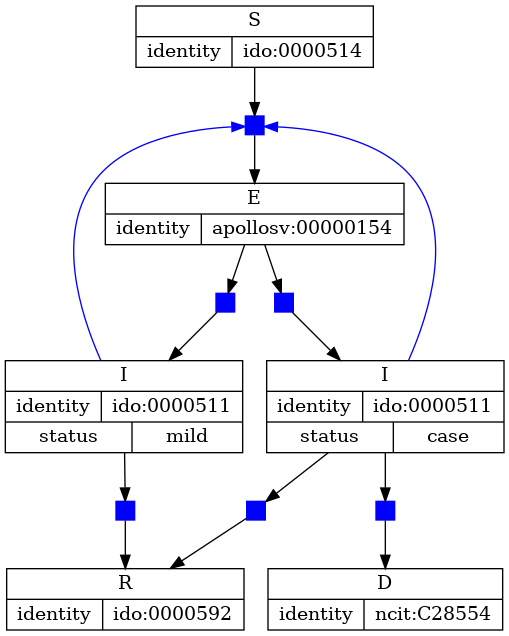

In [13]:
# Show graph of the base model
GraphicalModel.for_jupyter(seird_base)

### Stratifying by age
Each country's population is stratified by age and by the same age groups in intervals of 5 years from 0 up to 80 and then 80+.

In [14]:
age_strata = list(data['France']['population']['age_group'].values)
# Get a map from age group index to its label
age_group_map = {ix: label for ix, label in enumerate(age_strata, start=1)}

In [8]:
seird_base_age_strat = stratify(seird_base,
                                key='age',
                                strata=age_strata,
                                structure=[],
                                cartesian_control=True)
# GraphicalModel.for_jupyter(seird_base_age_strat)
# >>> Warning: graph has 4556 nodes...layout may take a long time.

In [15]:
initial_values = {}
data['France']['ompartment'].head(10)

,replicate,age_group,compartment,t,y
1,1,1,D,0.2,0
2,1,1,D,0.4,0
3,1,1,D,0.6,0
4,1,1,D,0.8,0
5,1,1,D,1.0,0
6,1,1,D,1.2,0
7,1,1,D,1.4,0
8,1,1,D,1.6,0
9,1,1,D,1.8,0
10,1,1,D,2.0,0
